<a href="https://colab.research.google.com/github/withoutsultang/Cat-and-Dog-CNN/blob/main/machineLearning_catvsdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**머신러닝 기말고사 프로젝트** [데이터셋](https://www.kaggle.com/datasets/tongpython/cat-and-dog)

# 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 라이브러리

In [ ]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from PIL import Image

# 데이터 로드

In [ ]:
root = '/content/drive/MyDrive/Colab Notebooks/content/archive'

In [ ]:
train_path = root + '/training_set/training_set'
test_path = root + '/test_set/test_set'

In [ ]:
data_len = len(os.listdir(train_path + "/cats")) + len(os.listdir(train_path + "/dogs"))
data_len

8067

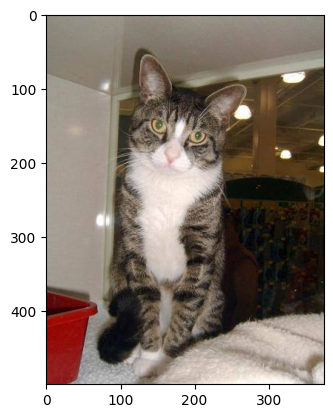

(499, 375, 3)

In [ ]:
img = Image.open(train_path + "/cats/cat.34.jpg")
img_np = np.array(img)
plt.imshow(img_np)
plt.show()
img_np.shape

# 데이터셋 클래스

In [ ]:
class CatandDog(Dataset):
  def __init__(self, root, transform=None):
    self.root = root
    self.transform = transform
    self.images = []

    for i in ['cats', 'dogs']:
      path = os.path.join(root, i)
      for image in os.listdir(path):
        if image != '_DS_Store':
          self.images.append(os.path.join(path, image))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, i):
    image_path = self.images[i]#os.path.join(self.root, self.images[i])
    image = Image.open(image_path).convert('RGB')
    if('dog' in self.images[i].lower()):
      label = 1.0
    else:
      label = 0.0

    if self.transform:
      image = self.transform(image)

    return image, label


데이터 전처리

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))
])

인스턴스 생성

In [ ]:
train = CatandDog(train_path, transform=transform)
test = CatandDog(test_path, transform=transform)

학습 시간 감소를 위한 데이터 분할

In [ ]:
reduced_size = int(1 * len(train))
_, reduced = torch.utils.data.random_split(train, [len(train)-reduced_size, reduced_size])

# VGG16 클래스

In [ ]:
class VGG16(nn.Module):
  def __init__(self, num_classes=1):
    super(VGG16, self).__init__()

    self.features = nn.Sequential(
        # Conv Block 1
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Conv Block 2
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Conv Block 3
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Conv Block 4
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Conv Block 5
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, num_classes),
        nn.Sigmoid()
    )

  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)  # 평탄화
      x = self.classifier(x)
      return x

# ResNet-18 클래스

In [ ]:
class ResNet18Binary(nn.Module):
    def __init__(self):
        super(ResNet18Binary, self).__init__()
        self.resnet = models.resnet18(pretrained=True)  # 사전 학습된 가중치 로드
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.resnet(x)

# 모델 학습을 위한 Trainer 클래스

In [ ]:
class Trainer():
  def __init__(self, model, optimizer, crit):
    self.model = model
    self.optimizer = optimizer
    self.crit = crit

    super().__init__()

  def train(self, train_loader, valid_loader, config):
    best_loss = np.inf
    best_model = None

    for i in range(config.n_epochs):
      train_loss, train_acc = self._train(train_loader, config)
      valid_loss, valid_acc = self._validate(valid_loader, config)

      if valid_loss <= best_loss:
        best_loss = valid_loss
        best_model = deepcopy(self.model.state_dict())

      print("Epoch(%d/%d): train_loss=%.4f valid_loss=%.4f best_loss=%.4f train_acc=%.2f valid_acc=%.2f" %(
          i + 1,
          config.n_epochs,
          train_loss,
          valid_loss,
          best_loss,
          train_acc * 100,
          valid_acc * 100,
      ))

    self.model.load_state_dict(best_model)

  def _train(self, loader, config):
    self.model.train()
    total_loss = 0
    corr = 0
    total = 0

    for x, y in loader:
      x, y = x.to(config.device), y.to(config.device).float().view(-1,1)
      y_hat = self.model(x)
      loss = self.crit(y_hat, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      total_loss += loss.item()

      predicted = (y_hat > 0.5).float()
      corr += (predicted == y).sum().item()
      total += y.size(0)

      avg_loss = total_loss / len(loader)
      accuracy = corr / total

    return avg_loss, accuracy

  def _validate(self, loader, config):
    self.model.eval()
    total_loss = 0
    corr = 0
    total = 0

    with torch.no_grad():
      for x,y in loader:
        x, y = x.to(config.device), y.to(config.device).float().view(-1,1)
        y_hat = self.model(x)
        loss = self.crit(y_hat, y)
        total_loss += loss.item()

        predicted = (y_hat > 0.5).float()
        corr = (predicted == y).sum().item()
        total = y.size(0)

      avg_loss = total_loss / len(loader)
      accuracy = corr / total

    return avg_loss, accuracy

# 모델 인자 설정 및 Main

In [ ]:
def define_arg():
  p = argparse.ArgumentParser()

  p.add_argument("--model_fn", required=False, default="/content/model_resnet18_bce.pth")
  p.add_argument("--gpu_id", type=int, default=0 if torch.cuda.is_available() else -1)
  p.add_argument("--batch_size", type=int, default=64)
  p.add_argument("--n_epochs", type=int, default=10)
  p.add_argument("--verbose", type=int, default=1)

  config = p.parse_args(args=[])
  config.device = torch.device("cuda:%d" % config.gpu_id if config.gpu_id >= 0 else "cpu")


  return config

In [ ]:
def main(config):
  train_size = int(len(reduced) * 0.8)
  valid_size=  len(reduced) - train_size
  train_data, valid_data = torch.utils.data.random_split(reduced, [train_size, valid_size] )

  train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True)
  valid_loader = DataLoader(valid_data, batch_size=config.batch_size, shuffle=True)

  model = ResNet18Binary().to(config.device)
  optimizer = optim.Adam(model.parameters(), lr=0.0003)
  crit = nn.BCELoss()

  trainer = Trainer(model, optimizer, crit)
  trainer.train(train_loader, valid_loader, config)

  torch.save({
      "model": trainer.model.state_dict(),
      "optimizer": trainer.optimizer.state_dict(),
      "config": config,
  }, config.model_fn)


if __name__ == "__main__":
  config = define_arg()
  main(config)

Epoch(1/10): train_loss=0.1015 valid_loss=0.0592 best_loss=0.0592 train_acc=96.17 valid_acc=100.00
Epoch(2/10): train_loss=0.0323 valid_loss=0.3861 best_loss=0.0592 train_acc=98.79 valid_acc=84.62
Epoch(3/10): train_loss=0.0311 valid_loss=0.0689 best_loss=0.0592 train_acc=98.96 valid_acc=100.00
Epoch(4/10): train_loss=0.0190 valid_loss=0.0826 best_loss=0.0592 train_acc=99.38 valid_acc=100.00
Epoch(5/10): train_loss=0.0170 valid_loss=0.0806 best_loss=0.0592 train_acc=99.41 valid_acc=100.00
Epoch(6/10): train_loss=0.0162 valid_loss=0.0781 best_loss=0.0592 train_acc=99.50 valid_acc=100.00
Epoch(7/10): train_loss=0.0177 valid_loss=0.0550 best_loss=0.0550 train_acc=99.36 valid_acc=92.31
Epoch(8/10): train_loss=0.0146 valid_loss=0.1396 best_loss=0.0550 train_acc=99.61 valid_acc=92.31
Epoch(9/10): train_loss=0.0121 valid_loss=0.1300 best_loss=0.0550 train_acc=99.58 valid_acc=92.31
Epoch(10/10): train_loss=0.0029 valid_loss=0.1130 best_loss=0.0550 train_acc=99.94 valid_acc=100.00


# 성능 평가 및 시각화

손실 및 정확도 그래프

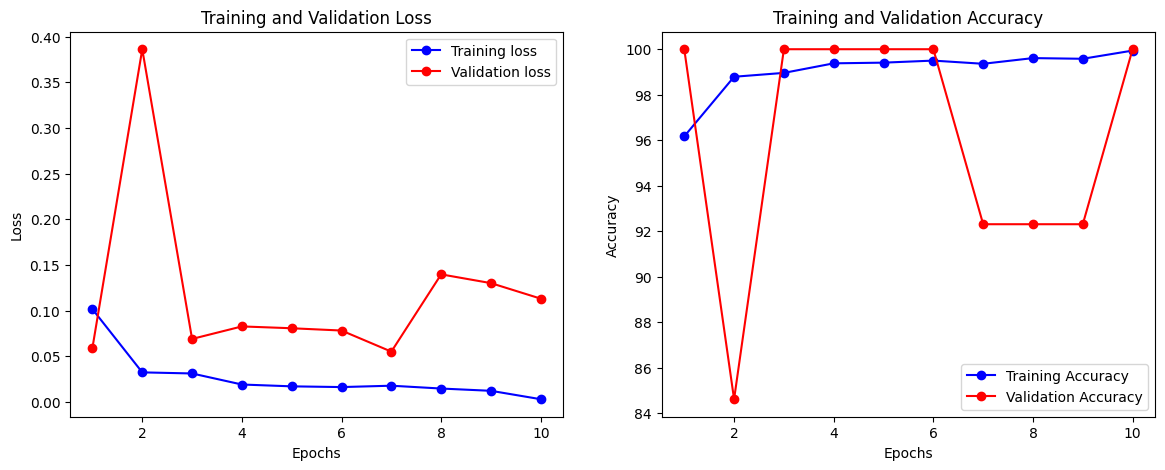

In [ ]:
def plot_training_history(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, valid_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 위에서 기록한 값
train_losses = [0.1015, 0.0323, 0.0311, 0.0190, 0.0170, 0.0162, 0.0177, 0.0146, 0.0121, 0.0029]
valid_losses = [0.0592, 0.3861, 0.0689, 0.0826, 0.0806, 0.0781, 0.0550, 0.1396, 0.1300, 0.1130]
train_accuracies = [96.17, 98.79, 98.96, 99.38, 99.41, 99.50, 99.36, 99.61, 99.58, 99.94]
valid_accuracies = [100.00, 84.62, 100.00, 100.00, 100.00, 100.00, 92.31, 92.31, 92.31, 100.00]

plot_training_history(train_losses, valid_losses, train_accuracies, valid_accuracies)


테스트 데이터 샘플 예측

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-104-a11b0765aa0b>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more deta

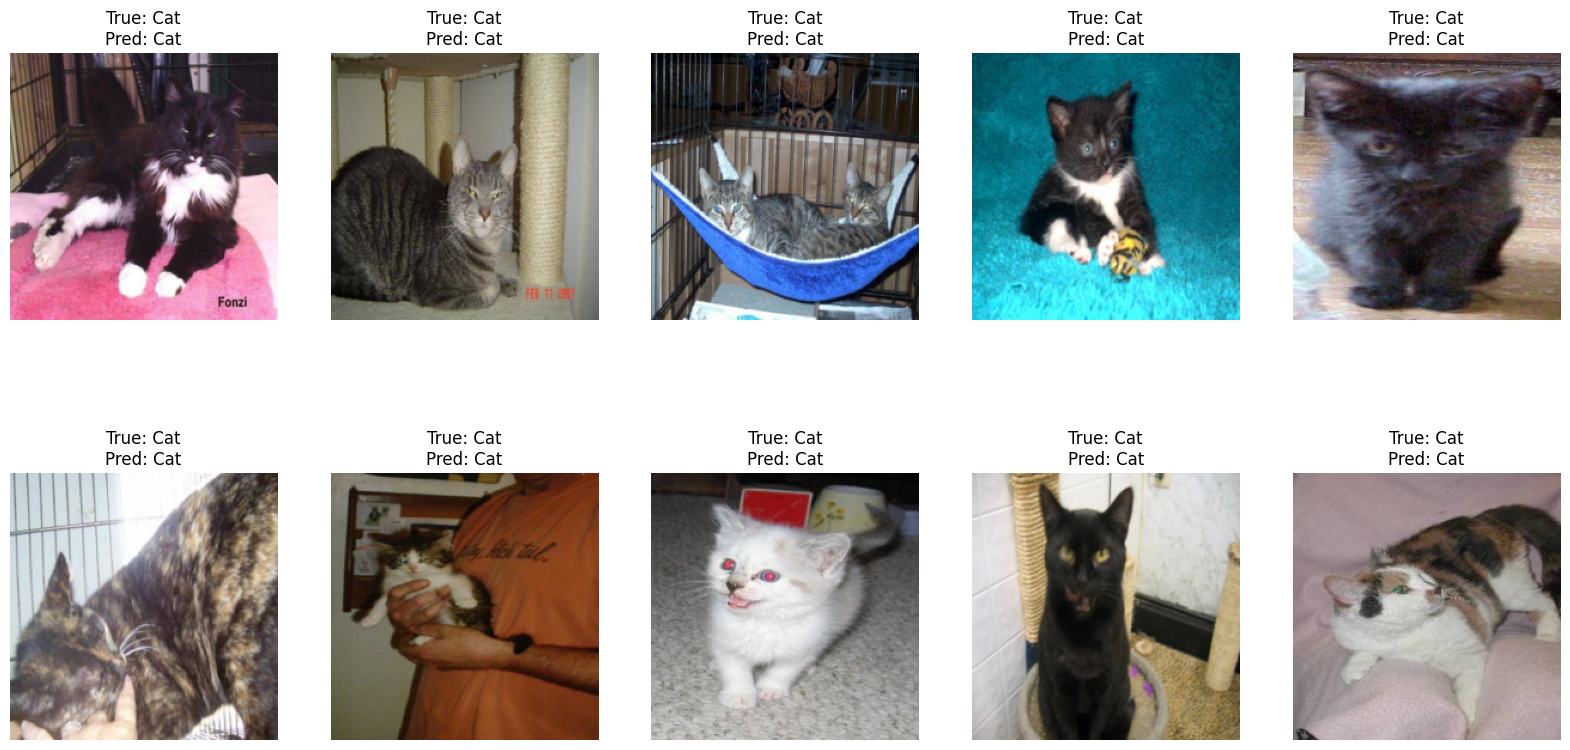

In [ ]:
def plot_sample_predictions(model, data_loader, device):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(data_loader))
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = torch.round(outputs)

        plt.figure(figsize=(20, 10))
        for i in range(10):
            ax = plt.subplot(2, 5, i + 1)
            img = images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5  # De-normalize
            plt.imshow(img)
            title = f"True: {'Dog' if labels[i] == 1 else 'Cat'}\nPred: {'Dog' if predictions[i] == 1 else 'Cat'}"
            plt.title(title)
            plt.axis('off')

        plt.show()

model_path = "/content/model_resnet18_bce.pth"

model = ResNet18Binary()
model.load_state_dict(torch.load(model_path)["model"])
test_loader = DataLoader(test, batch_size=64, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 테스트 데이터 샘플 예측 결과 시각화
plot_sample_predictions(model, test_loader, device)


혼동 행렬

<ipython-input-13-ed3e54b7403a>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)  # map_location을 사용하여 CPU 환경에서도 로드

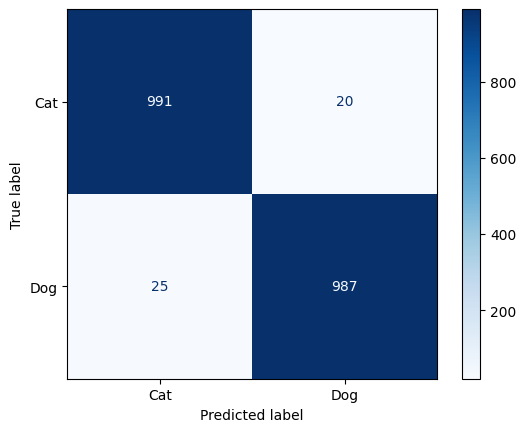

In [ ]:
def plot_confusion_matrix(model, data_loader, device):
    all_preds = []
    all_labels = []
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.round(outputs).cpu().numpy()
            labels = labels.cpu().numpy()

            all_preds.extend(preds.flatten())
            all_labels.extend(labels.flatten())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
    disp.plot(cmap='Blues')
    plt.show()
model_path = "/content/model_resnet18_bce.pth"

model = ResNet18Binary()

test_loader = DataLoader(test, batch_size=64, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model'])
# test_loader에 대한 혼동 행렬 시각화
plot_confusion_matrix(model, test_loader, device)
